# Loading the data from the notes

In [2]:
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
from llama_index.vector_stores.duckdb import DuckDBVectorStore
from llama_index.core import StorageContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import pathlib
import pandas as pd
import glob
import PyPDF2
from collections import Counter
import fitz
import os
import re

### Metadata extraction & data loading

In [3]:
# Load the excel sheet where I've manually logged all the metadata
metadata_df = pd.read_excel(
    r"../config/data_organisation.xlsx",
    index_col=0
)

problem - not all our filenames match the keys. I made some errors in copying. Maybe I can do a simple fuzzy match? Performance is not a concern here...

In [4]:
def match_name(name, df, min_score=0):
    max_score = -1
    max_name = ""

    processed_name = re.sub(r'[^a-zA-Z0-9]', '', name)
    
    for n in df.index.tolist():
        processed_n = re.sub(r'[^a-zA-Z0-9]', '', n)
        
        # Calculate different string similarity metrics
        ratio_score = fuzz.ratio(processed_name, processed_n)
        partial_ratio_score = fuzz.partial_ratio(processed_name, processed_n)
        token_sort_ratio_score = fuzz.token_sort_ratio(processed_name, processed_n)
        token_set_ratio_score = fuzz.token_set_ratio(processed_name, processed_n)
        
        # Calculate weighted average of the scores
        weighted_score = (0.4 * ratio_score + 0.3 * partial_ratio_score + 0.2 * token_sort_ratio_score + 0.1 * token_set_ratio_score) / 100
        
        if weighted_score > min_score:
            if weighted_score > max_score:
                max_name = n
                max_score = weighted_score
            elif weighted_score == max_score and len(n) < len(max_name):
                max_name = n
                max_score = weighted_score
    
    return (max_name, max_score)

file_name = 'monetary policy report 2023'
nm, _ = match_name(file_name, metadata_df)
metadata_df.loc[nm].to_dict()
print(nm)

Monetary policy report November 2023


This works - lets wrap this in a function to work for the llamaindex boilerplate

In [5]:
def match_notes_metadata(file_path: str, metadata_df: pd.DataFrame):
    """Match the metadata using the file name and the manual extracts
    I pasted into the 'data organisation' spreadsheet. 

    Args:
        file_path (str): absolute file path to the pdf to match
        metadata_df (pd.DataFrame): dataframe of the data organisation spreadsheet

    Returns:
        dict: dictionary containing the matched metadata
    """
    file_name = file_path.split('\\')[-1]
    idx_nm, _ = match_name(file_name, metadata_df)
    matched_metadata = metadata_df.loc[idx_nm].to_dict()
    
    return matched_metadata

def get_random_metadata(file_path: str):
    """Dummy function to demonstrate how we could extract extra
    metadata from the text. We're going to need to make this 
    much more sophisticated.

    Args:
        file_path (str): absolute file path to the pdf

    Returns:
        dict: collection of random metadata
    """
    random_metadata = {}
    # Read the document and extract metadata as a dictionary
    with open(file_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)

        # Get the number of characters in the pdf
        text = ''
        for page in pdf_reader.pages:
            text += page.extract_text()
        random_metadata['num_characters'] = len(text)

        # Get the number of words in the pdf
        words = text.split()
        random_metadata['num_words'] = len(words)

        # Get the most common 5 words in the pdf
        word_counts = Counter(words)
        random_metadata['most_common_words'] = dict(word_counts.most_common(5))

    return random_metadata

Let's create a function to extract links

In [6]:
def extract_links_from_pdf(file_path):
    # Open the PDF file
    doc = fitz.open(file_path)

    links = []

    # Iterate over PDF pages
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)

        # Extract links
        links_on_page = page.get_links()

        # Iterate over links and append to list
        for link in links_on_page:
            if 'uri' in link.keys():
                links.append(link['uri'])

    return links

# Use the function
pdf_file = "../data/01_raw/monetary policy report february 2024.pdf"
print(extract_links_from_pdf(pdf_file))

['https://www.gov.uk/government/publications/monetary-policy-remit-autumn-statement-2023', 'http://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024', 'http://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024', 'https://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024#chapter-10', 'https://www.federalreserve.gov/newsevents/speech/files/yellen20170926a.pdf', 'https://www.bankofengland.co.uk/speech/2018/andy-haldane-advisory-conciliation-and-arbitration-service-future-of-work-conference', 'https://www.bankofengland.co.uk/speech/2018/andy-haldane-advisory-conciliation-and-arbitration-service-future-of-work-conference', 'https://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024#chapter-10', 'https://www.bankofengland.co.uk/monetary-policy-report/2024/february-2024#chapter-10', 'https://www.bankofengland.co.uk/monetary-policy-report/2023/may-2023', 'https://www.bankofengland.co.uk/credit-conditions-survey/2023/2023-q4', 'https

In [7]:
def get_metadata(file_path: str):
    """Gather all the metadata into one spot

    Args:
        file_path (str): absolute file path to pdf 

    Returns:
        dict: collection of our metadata
    """
    
    matched_metadata = match_notes_metadata(file_path, metadata_df)
    random_metadata = get_random_metadata(file_path)

    
    total_metadata = {
        **matched_metadata, 
        **random_metadata, 
        'links': extract_links_from_pdf(file_path)
    }
    
    # Convert all metadata to strings
    total_metadata = {k: str(v) for k, v in total_metadata.items()}

    return total_metadata

In [8]:
# Load the documents
path_to_docs = pathlib.PurePosixPath(r"../data/01_raw")
documents = SimpleDirectoryReader(path_to_docs, file_metadata=get_metadata).load_data()

In [9]:
documents[0]

Document(id_='d30dcf1d-25f4-40fe-b177-a4ade33203bd', embedding=None, metadata={'page_label': 'Cover', 'file_name': '/Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/notebooks/../data/01_raw/MPR November 2023.pdf', 'Description': 'Our quarterly Monetary Policy Report sets out the economic analysis and inflation projections that the Monetary Policy Committee uses to make its interest rate decisions.', 'Type': 'MPR', 'Date': '2023-02-11 00:00:00', 'Authors': 'Bank of England', 'Topics': 'Inflation, GDP, Labour Market, Forecasts', 'Brands': 'MPR', 'Academic Research Cited?': 'No', 'Divisions': 'Monetary Analysis', 'MPC Round': 'Nov 2023', 'Forecast Round': 'Nov 2023', 'Tags': 'nan', 'Related Notes': 'nan', 'num_characters': '191572', 'num_words': '30758', 'most_common_words': "{'the': 1753, 'of': 1017, 'to': 935, 'in': 931, 'and': 651}", 'links': "['https://www.bankofengland.co.uk/monetary-policy-report/2023/november-2023#chapter-10', 'https://www.bank

# At this point - lets consider this metadata fixed
Now we need to consider how to create distance metrics for all the different dimensions

| Dimension | Distance Metric | Notes | Apply? |
| - | - | - | - |
| Node text | Difference between embeddings | Standard | ✅ |
| Source File | Boolean | Is same or isn't the same. Might be useful as a dummy feature? | ❌ |
| Description | Difference between emeddings | Should I just add this to the original text? | ✅ |
| Type | Categorical - needs manual construction | Either this is a yes/no distance metric, or I need to construct some sort of logical structure | ✅ |
| Date | Simple difference between dates | Need to engineer this feature. Either simple difference, or the quarterly difference, etc | ✅ |
| Authors | Boolean | Is same or isnt - but at the same time there can be multiple overlapping authors | ✅ |
| Topics | Categorical - manual | Simple fuzzy-match of Hamming distance / Jaccard index or something more sophisticated built on a knowledge graph | ✅ | 
| Brands | Similar to that above - fuzzy match of Hamming distance. There are also nested distances? | Difficult to deal with the nesting | ✅ |
| Academic Research Cited? | Not sure | Could use as a flag to do a deeper index and search for related concepts in the cited academic papers? | ❌ |
| Divisions | Some sort of manual construct | Need to create a manual listing to map the categories together here | ✅ |
| MPC Round | Boolean? Or also some distance due to date? | Not sure | ✅ |
| Forecast Round | Same as above | N/A | ✅ |
| Tags | N/A | These are always empty | ❌ |
| Related Notes | N/A | These are always empty | ❌ |
 

# OTHER STUFF FOR EMEDDINGS INDEX

In [10]:
# this breaks the code as I'm lazy

### Persist the data into a db

In [11]:
path_to_db = pathlib.PurePosixPath(r"../data/02_processed") 

# Check if the file exists
if os.path.exists(path_to_db / "pg.duckdb"):
    # Delete the file
    os.remove(path_to_db / "pg.duckdb")

# Instantiate the vector store
vector_store = DuckDBVectorStore("pg.duckdb", persist_dir=str(path_to_db))

### Configure the embedd model

In [12]:
# Instantiate the db
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

In [13]:
# embed_model.get_text_embedding("hello world")

### Configure the boilerplate

In [14]:
# Configure things to point in the right place
Settings.embed_model = embed_model
Settings.chunk_size = 3024

storage_settings = StorageContext.from_defaults(
    vector_store=vector_store,
)

### Construct the index and save

In [15]:
# Construct the index
index = VectorStoreIndex.from_documents(documents, storage_context=storage_settings)

### Load the index from the vector db

In [16]:
# Load the vector store from local
vector_store = DuckDBVectorStore.from_local(str(path_to_db/"pg.duckdb"))
index = VectorStoreIndex.from_vector_store(vector_store)

### Query

In [17]:
# Now we can retrieve similar documents to a given query
query_text = "What is the forecast"

results = index.as_retriever().retrieve(query_text)

print(len(results))
print(results[0].text)
print(results[0].metadata)

2
Monetary policy at the Bank of England
The objectives of monetary policy
The Bank’s Monetary Policy Committee (MPC) sets monetary policy to keep inflation low and stable,
which supports growth and jobs. Subject to maintaining price stability , the MPC is also required to
support the Government’s economic policy.
The Government has set the MPC a target for the 12-month increase in the Consumer Prices Index
of 2%.
The 2% inflation target is symmetric and applies at all times.
The MPC’s remit recognises, however, that the actual inflation rate will depart from its target as a
result of shocks and disturbances, and that attempts to keep inflation at target in these circumstances
may cause undesirable volatility in output. In exceptional circumstances, the appropriate horizon for
returning inflation to target can vary. The MPC will communicate how and when it intends to return
inflation to the target.
The instruments of monetary policy
The MPC currently uses two main monetary policy tools

# POC1: Distance Metric for Node Text

Technically this isn't too difficult - we're just making the embeddings and creating a function which compares them.

In [28]:
# First, for each document, we fill in the embedding metadata model

# from sentence_transformers import SentenceTransformer

for doc in documents:
    doc.embedding = embed_model.get_text_embedding(doc.text)
    # sent_embed = SentenceTransformer('all-MiniLM-L6-v2').encode(doc.text)
    # break

    # break

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cosine_similarity(np.array(documents[0].embedding).reshape(1, -1), np.array(documents[1].embedding).reshape(1, -1))

def text_distance_metric(doc1, doc2):
    return cosine_similarity(np.array(doc1.embedding).reshape(1, -1), np.array(doc2.embedding).reshape(1, -1))[0][0]

# POC2: Distance Metric for Document Name
Again - lets use the embeddings for semantic similarity and a levenstein distance for the string (syntactic) similarity

In [ ]:
test_name_1 = documents[0].metadata['file_name'].split("/")[-1].split(".")[0]
test_name_2 = documents[1].metadata['file_name'].split("/")[-1].split(".")[0]
test_name_3 = documents[-1].metadata['file_name'].split("/")[-1].split(".")[0]

test_name_1, test_name_2, test_name_3

('MPR November 2023',
 'MPR November 2023',
 'monetary policy report february 2024')

In [ ]:
def semantic_similarity(doc0, doc1):
    doc0_emb = embed_model.get_text_embedding(doc0.metadata['file_name'].split("/")[-1].split(".")[0])
    doc1_emb = embed_model.get_text_embedding(doc1.metadata['file_name'].split("/")[-1].split(".")[0])
    return cosine_similarity(np.array(doc0_emb).reshape(1, -1), np.array(doc1_emb).reshape(1, -1))

print(semantic_similarity(documents[0], documents[-1]))
print(semantic_similarity(documents[0], documents[0]))

[[0.69027683]]
[[1.]]


In [ ]:
from Levenshtein import ratio

def syntactic_similarity(doc0, doc1):
    doc0_name = doc0.metadata['file_name'].split("/")[-1].split(".")[0]
    doc1_name = doc1.metadata['file_name'].split("/")[-1].split(".")[0]
    score = ratio(doc0_name, doc1_name)
       
    scaled_score = 2 * (score - 0) / (1 - 0) - 1
    
    return scaled_score


print(syntactic_similarity(documents[0], documents[-1]))
print(syntactic_similarity(documents[0], documents[0]))

-0.320754716981132
1.0


In [ ]:
def name_distance_metric(doc0, doc1):
    return 0.3 * syntactic_similarity(doc0, doc1) + 0.7 * semantic_similarity(doc0, doc1)[0][0] # Random weights
    
print(name_distance_metric(documents[0], documents[-1]))

0.3869673627989685


# POC3: Distance Metric for Description

Simply use the embeddings for semantic similarity

In [ ]:
def description_distance_metric(doc0, doc1):
    """Use the cosine distance between the description embeddings to 
    calculate the distance between the two documents

    Args:
        doc0 (_type_): _description_
        doc1 (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc0_desc = doc0.metadata['Description']
    doc1_desc = doc1.metadata['Description']
    
    doc0_emb = embed_model.get_text_embedding(doc0_desc)
    doc1_emb = embed_model.get_text_embedding(doc1_desc)
    
    return cosine_similarity(np.array(doc0_emb).reshape(1, -1), np.array(doc1_emb).reshape(1, -1))[0][0]

# Test the function
print(description_distance_metric(documents[0], documents[-1]))

0.6220706423974953


# POC4: Distance Metric for Type

Categorical which needs manual construction, given I hold the understanding of similarity here.

In [ ]:
# I only have one type of document (MPR) in this test set, so will use dummies for now
# I reckon we can calculate this based on initially constructing a knowledge graph of the documents.

# Higher is more similar
doc_knowledge_graph = {
    'MPR': {
        'press release': 0.0,
        'research paper': 0.9,
        'speech': 0.6
    },
    'press release': {
        'research paper': 0.9,
        'speech': 0.7
    },
    'research paper': {
        'speech': 0.7
    },
    'speech': {}
}

def calculate_doctype_distance(doc_type1, doc_type2, doc_knowledge_graph):
    # If the document types are the same, return 1
    if doc_type1 == doc_type2:
        return 1    
    
    # Check if the document types exist in the knowledge graph
    if doc_type1 not in doc_knowledge_graph or doc_type2 not in doc_knowledge_graph:
        return "Document types not found in the knowledge graph"

    # Get the distance from the knowledge graph
    distance = doc_knowledge_graph[doc_type1].get(doc_type2, doc_knowledge_graph[doc_type2].get(doc_type1))

    if distance is None:
        return "No path found between the document types in the knowledge graph"

    # Scale the distance to be between -1 and 1
    scaled_distance = round(2 * (distance - 0.5), 2)

    return scaled_distance

# Test the function
print(calculate_doctype_distance('press release', 'MPR', doc_knowledge_graph))
print(calculate_doctype_distance('MPR', 'press release', doc_knowledge_graph))
print(calculate_doctype_distance('MPR', 'MPR', doc_knowledge_graph))

-1.0
-1.0
1


# POC5: Distance Metric for Date

Simple difference between dates

In [ ]:
import numpy as np
from datetime import datetime, timedelta


def scale_date_difference(date0, date1):
    
    # Date 0 is our base date
    # Date 1 is the document we're comparing.
    
    # Try to convert the dates to datetime objects
    date0 = pd.to_datetime(date0)
    date1 = pd.to_datetime(date1) 
    diff = (date0 - date1).days

    # Intuition - if date 1 > date 0 by a lot then it likely isn't related at all
    if diff < -90:
        return -1
    
    # Intuition - if date 1 < date 0 by a lot then it likely isn't related at all
    elif diff > 365:
        return -1
    
    # Intuition - if the difference is within a week, return 1
    elif -15 < diff < 15:
        return 1
    
    # Scale the diff to be between -1 and 1, with the min and max values being -365 and +365
    else:
        scaled_diff = 2 * (diff + 365) / (365 + 365) - 1
        # Return the scaled diff as the output of a smoothing 1/x function
        return 1 / (0.5 + scaled_diff **2) - 1

# Test the function
scale_date_difference(documents[0].metadata['Date'], documents[-1].metadata['Date'])

-1

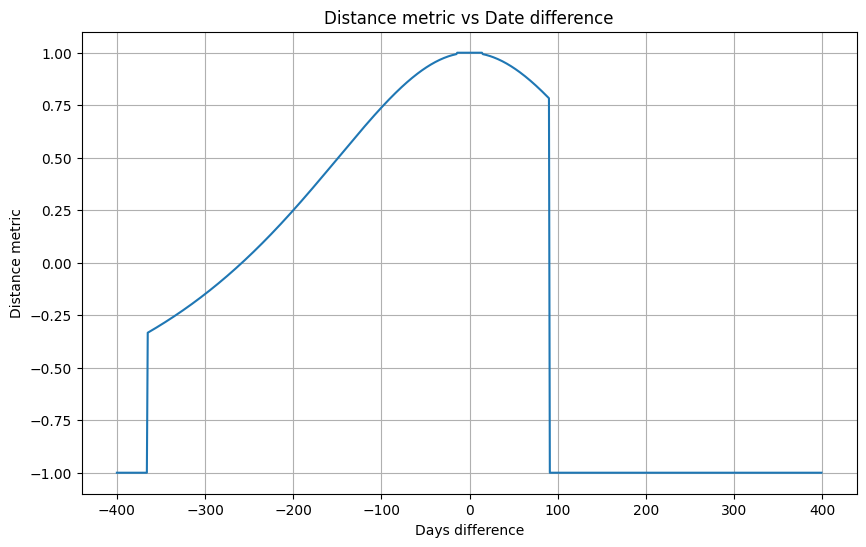

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Assume the scale_date_difference function is defined here

# Generate a range of dates from 2 years ago to 2 years in the future
reference_date = datetime.now()
dates = [reference_date + timedelta(days=i) for i in range(-400, 400)]

# Calculate the scaled difference for each date
scaled_differences = [scale_date_difference(reference_date, date) for date in dates]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(-400, 400)], scaled_differences)
# plt.axvline(x=reference_date, color='red', linestyle='dotted')
plt.xlabel('Days difference')
plt.ylabel('Distance metric')
plt.title('Distance metric vs Date difference')
plt.grid(True)
plt.show()

# POC6: Distance Metric for Authors

Simple Jaccard similarity. 

Might need more sophistication in how we weight authors and the number of them involved.

In [ ]:
test_author_list_0 = ['John Doe', 'James Doe', 'Bob Smith']
test_author_list_1 = ['John Doe', 'James Doe', 'Bob Smith']
test_author_list_2 = 'John Doe'
test_author_list_3 = ['John Doe', 'James Doe', 'Bob Smith', 'Jane Doe']

def fuzzy_jaccard_similarity(set1, set2, threshold):
    
    # Deal with the case where either one of the inputs are single item strings
    if isinstance(set1, str) | isinstance(set2, str):
        return fuzz.ratio(set1, set2) / 100
    
    if isinstance(set1, str):
        return fuzz.ratio(set1, set2) / 100
    
    if len(set1) == 0 and len(set2) == 0:
        return 0.0

    
    intersection = set()
    for el1 in set1:
        if el1.strip():  # Check if el1 is not an empty string
            el2, similarity = process.extractOne(el1, set2)
            if similarity >= threshold:
                intersection.add(el1)
                
    union = len(set1) + len(set2) - len(intersection)
    return len(intersection) / union if union != 0 else 0  # Add a check to prevent division by zero

def author_distance_metric(authors0, authors1, fuzz_thresh=90):
    
    if isinstance(authors0, str):
        authors0 = [authors0]
    
    if isinstance(authors1, str):
        authors1 = [authors1]
        
    # Calculate the Jaccard similarity between the two author lists
    jacc_sim = fuzzy_jaccard_similarity(set(authors0), set(authors1), threshold=fuzz_thresh)
    
    # Scale the Jaccard similarity to be between -1 and 1
    scaled_similarity = 2 * jacc_sim - 1
    
    return scaled_similarity

author_distance_metric(test_author_list_0, test_author_list_1)

1.0

# POC7: Topics

Could either do a Jaccard similarity, or use a knowledge graph of related topics.

Not sure how to ex-ante construct this knowledge graph. There is this one https://arxiv.org/pdf/2010.05172.pdf but they don't actually make it shareable...

I believe there are also nested topics - not sure how to deal with this right now... I suspect just a simple Jaccard will do...

In [ ]:
def topic_distance_metric(doc0, doc1, fuzz_thresh=80):
    # Get the topics from the metadata
    topics0 = doc0.metadata['Topics'].split(',')
    topics1 = doc1.metadata['Topics'].split(',')
    
    # Calculate the Jaccard similarity between the two topic lists
    jacc_sim = fuzzy_jaccard_similarity(set(topics0), set(topics1), threshold=fuzz_thresh)
    
    # Scale the Jaccard similarity to be between -1 and 1
    scaled_similarity = 2 * jacc_sim - 1
    
    return scaled_similarity

topic_distance_metric(documents[0], documents[1], fuzz_thresh=80)

1.0

In [ ]:
documents[0].metadata['Topics']

'Inflation, GDP, Labour Market, Forecasts'

# POC8: Brands
Same as topics - but I believe there are nested brands. Not sure how to deal with this right now...

In [ ]:
def brand_distance_metric(doc0, doc1, fuzz_thresh=80):
    # Get the brands from the metadata
    brands0 = doc0.metadata['Brands']
    brands1 = doc1.metadata['Brands']
    
    # Calculate the Jaccard similarity between the two brand lists
    jacc_sim = fuzzy_jaccard_similarity(set(brands0), set(brands1), threshold=fuzz_thresh)
    
    # Scale the Jaccard similarity to be between -1 and 1
    scaled_similarity = 2 * jacc_sim - 1
    
    return scaled_similarity

# Test the function
print(documents[0].metadata['Brands'],"|",documents[-1].metadata['Brands'])

brand_distance_metric(documents[0], documents[-1], fuzz_thresh=80)


MPR | MPR


1.0

# POC9: Division

Again - simple jaccard similarity


In [ ]:
def division_distance_metric(doc0, doc1, fuzz_thresh=80):
    # Get the divisions from the metadata
    divisions0 = doc0.metadata['Divisions']
    divisions1 = doc1.metadata['Divisions']
    
    if isinstance(divisions0, str):
        divisions0 = [divisions0]
        
    if isinstance(divisions1, str):
        divisions1 = [divisions1]
    
    # Calculate the Jaccard similarity between the two division lists
    jacc_sim = fuzzy_jaccard_similarity(set(divisions0), set(divisions1), threshold=fuzz_thresh)
    
    # Scale the Jaccard similarity to be between -1 and 1
    scaled_similarity = 2 * jacc_sim - 1
    
    return scaled_similarity

# Test the function
print(documents[0].metadata['Divisions'],"|",documents[-1].metadata['Divisions'])

division_distance_metric(documents[0], documents[-1], fuzz_thresh=80)


Monetary Analysis | Monetary Analysis


1.0

# POC10: MPC Round

Simple date distance difference, but quantised to quarters

In [ ]:
def mpc_round_distance_metric(doc0, doc1):
    # Get the MPC round from the metadata
    mpc_round0 = doc0.metadata['MPC Round']
    mpc_round1 = doc1.metadata['MPC Round']
    
    # If the MPC round is the same, return 1
    if mpc_round0 == mpc_round1:
        return 1
    
    # If the MPC round is different, return -1
    else:
        return -1
    
# Test the function
mpc_round_distance_metric(documents[0], documents[-1])

-1

# POC11: Forecast Round

Same as mpc_round


In [ ]:
def forecast_round_distance_metric(doc0, doc1):
    # Get the forecast round from the metadata
    forecast_round0 = doc0.metadata['Forecast Round']
    forecast_round1 = doc1.metadata['Forecast Round']
    
    # If the forecast round is the same, return 1
    if forecast_round0 == forecast_round1:
        return 1
    
    # If the forecast round is different, return -1
    else:
        return -1
    
forecast_round_distance_metric(documents[0], documents[-1])

-1

# Calculate final composite vector of all the distances


In [ ]:
def calculate_distance_vector(doc0, doc1):
    # Calculate the distance metrics for each metadata field
    text_distance = text_distance_metric(doc0, doc1)
    name_distance = name_distance_metric(doc0, doc1)
    description_distance = description_distance_metric(doc0, doc1)
    doctype_distance = calculate_doctype_distance(doc0.metadata['Type'], doc1.metadata['Type'], doc_knowledge_graph)
    date_distance = scale_date_difference(doc0.metadata['Date'], doc1.metadata['Date'])
    author_distance = author_distance_metric(doc0.metadata['Authors'], doc1.metadata['Authors'])
    topic_distance = topic_distance_metric(doc0, doc1)
    brand_distance = brand_distance_metric(doc0, doc1)
    division_distance = division_distance_metric(doc0, doc1)
    mpc_round_distance = mpc_round_distance_metric(doc0, doc1)
    forecast_round_distance = forecast_round_distance_metric(doc0, doc1)
    
    # Construct the distance vector
    distance_vector = [
        text_distance,
        name_distance,
        description_distance,
        doctype_distance,
        date_distance,
        author_distance,
        topic_distance,
        brand_distance,
        division_distance,
        mpc_round_distance,
        forecast_round_distance
    ]
    
    return distance_vector

# Test the function
calculate_distance_vector(documents[0], documents[-1])

[0.6246020756456541,
 0.3869673627989685,
 0.6220706423974953,
 1,
 -1,
 1.0,
 1.0,
 1.0,
 1.0,
 -1,
 -1]

This distance vector would be the input into our neural network, or whatever classifier model we choose.

In [ ]:
documents[0].metadata

{'page_label': 'Cover',
 'file_name': '/Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/notebooks/../data/01_raw/MPR November 2023.pdf',
 'Description': 'Our quarterly Monetary Policy Report sets out the economic analysis and inflation projections that the Monetary Policy Committee uses to make its interest rate decisions.',
 'Type': 'MPR',
 'Date': '2023-02-11 00:00:00',
 'Authors': 'Bank of England',
 'Topics': 'Inflation, GDP, Labour Market, Forecasts',
 'Brands': 'MPR',
 'Academic Research Cited?': 'No',
 'Divisions': 'Monetary Analysis',
 'MPC Round': 'Nov 2023',
 'Forecast Round': 'Nov 2023',
 'Tags': 'nan',
 'Related Notes': 'nan',
 'num_characters': '191572',
 'num_words': '30758',
 'most_common_words': "{'the': 1753, 'of': 1017, 'to': 935, 'in': 931, 'and': 651}",
 'links': "['https://www.bankofengland.co.uk/monetary-policy-report/2023/november-2023#chapter-10', 'https://www.bankofengland.co.uk/monetary-policy-report/2023/november-2023#cha

In [32]:
import sys
metadata_dict = {}
for doc in documents:
    metadata_dict[doc.metadata['file_name']] = doc.metadata
    
sys.getsizeof(metadata_dict)

232

In [33]:
sys.getsizeof(documents)

1656